# 캘리포니아 주택 가격 예측

### 기본 정보

- 인구, 중간소득 등의 특성을 사용하여 주택 가격 예측
- 다중 회귀, 단방향 회귀(반대 : 다변량 회귀)
    - 다중 회귀 : 여러 개의 특성을 이용한 회귀
    - 단방향 회귀 : 하나의 데이터에 대한 예측
    - 다변량 회귀 : 여러 개의 수치를 예측하기 위한 회귀
- 회귀의 성능 측정 방법
    - 평균 제곱근의 오차를 활용
    - 평균 절대오차를 활용

- 일차적으로 파이썬 커널을 설정하면서 정상적으로 import가 되는지 체크해주었다. 
- 커널에 원하는 import 추가하는 법
    1. `venv`로 커널을 생성해준다. 
    2. `source .venv/bin/activate`로 venv를 활성화해준다. 
    3. 내부에서 `pip install`로 원하는 라이브러리를 다운로드 받는다. 

In [1]:
import sys

assert sys.version_info >= (3, 5)

import sklearn

assert sklearn.__version__ >= "0.20"

import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

ROOT_DIR = '.'
CHAPTER_ID = 'end_to_end_project'
IMAGE_PATH = os.path.join(ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension = 'png', resolution = 100): 
    path = os.path.join(IMAGE_PATH, fig_id + '.' + fig_extension)
    print('그림 저장 : ', fig_id)

    if tight_layout:
        plt.tight_layout()
    
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings

warnings.filterwarnings(action='ignore', message='^internal gelsd')


# 데이터 가져오기

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


In [3]:

fetch_housing_data()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21244\445020470.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


In [4]:
import pandas as pd

csv_path = os.path.join(HOUSING_PATH, "housing.csv")

pd.read_csv(csv_path)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
pd.read_csv(csv_path).head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


- 해당 데이터는 대부분 수치로 되어있다. 
- longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, ocean_proximity가 존재하고, dictionary구조로 데이터를 뽑아내들 수 있다. 

In [6]:
housing = pd.read_csv(csv_path)

- pandas를 통해 읽어온 데이터셋은 `describe()`를 이용해 데이터 요약본을 알 수 있다. 하지만, 이는 숫자형 데이터만 조회가능

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


그림 저장 :  attribute_histogram_plots


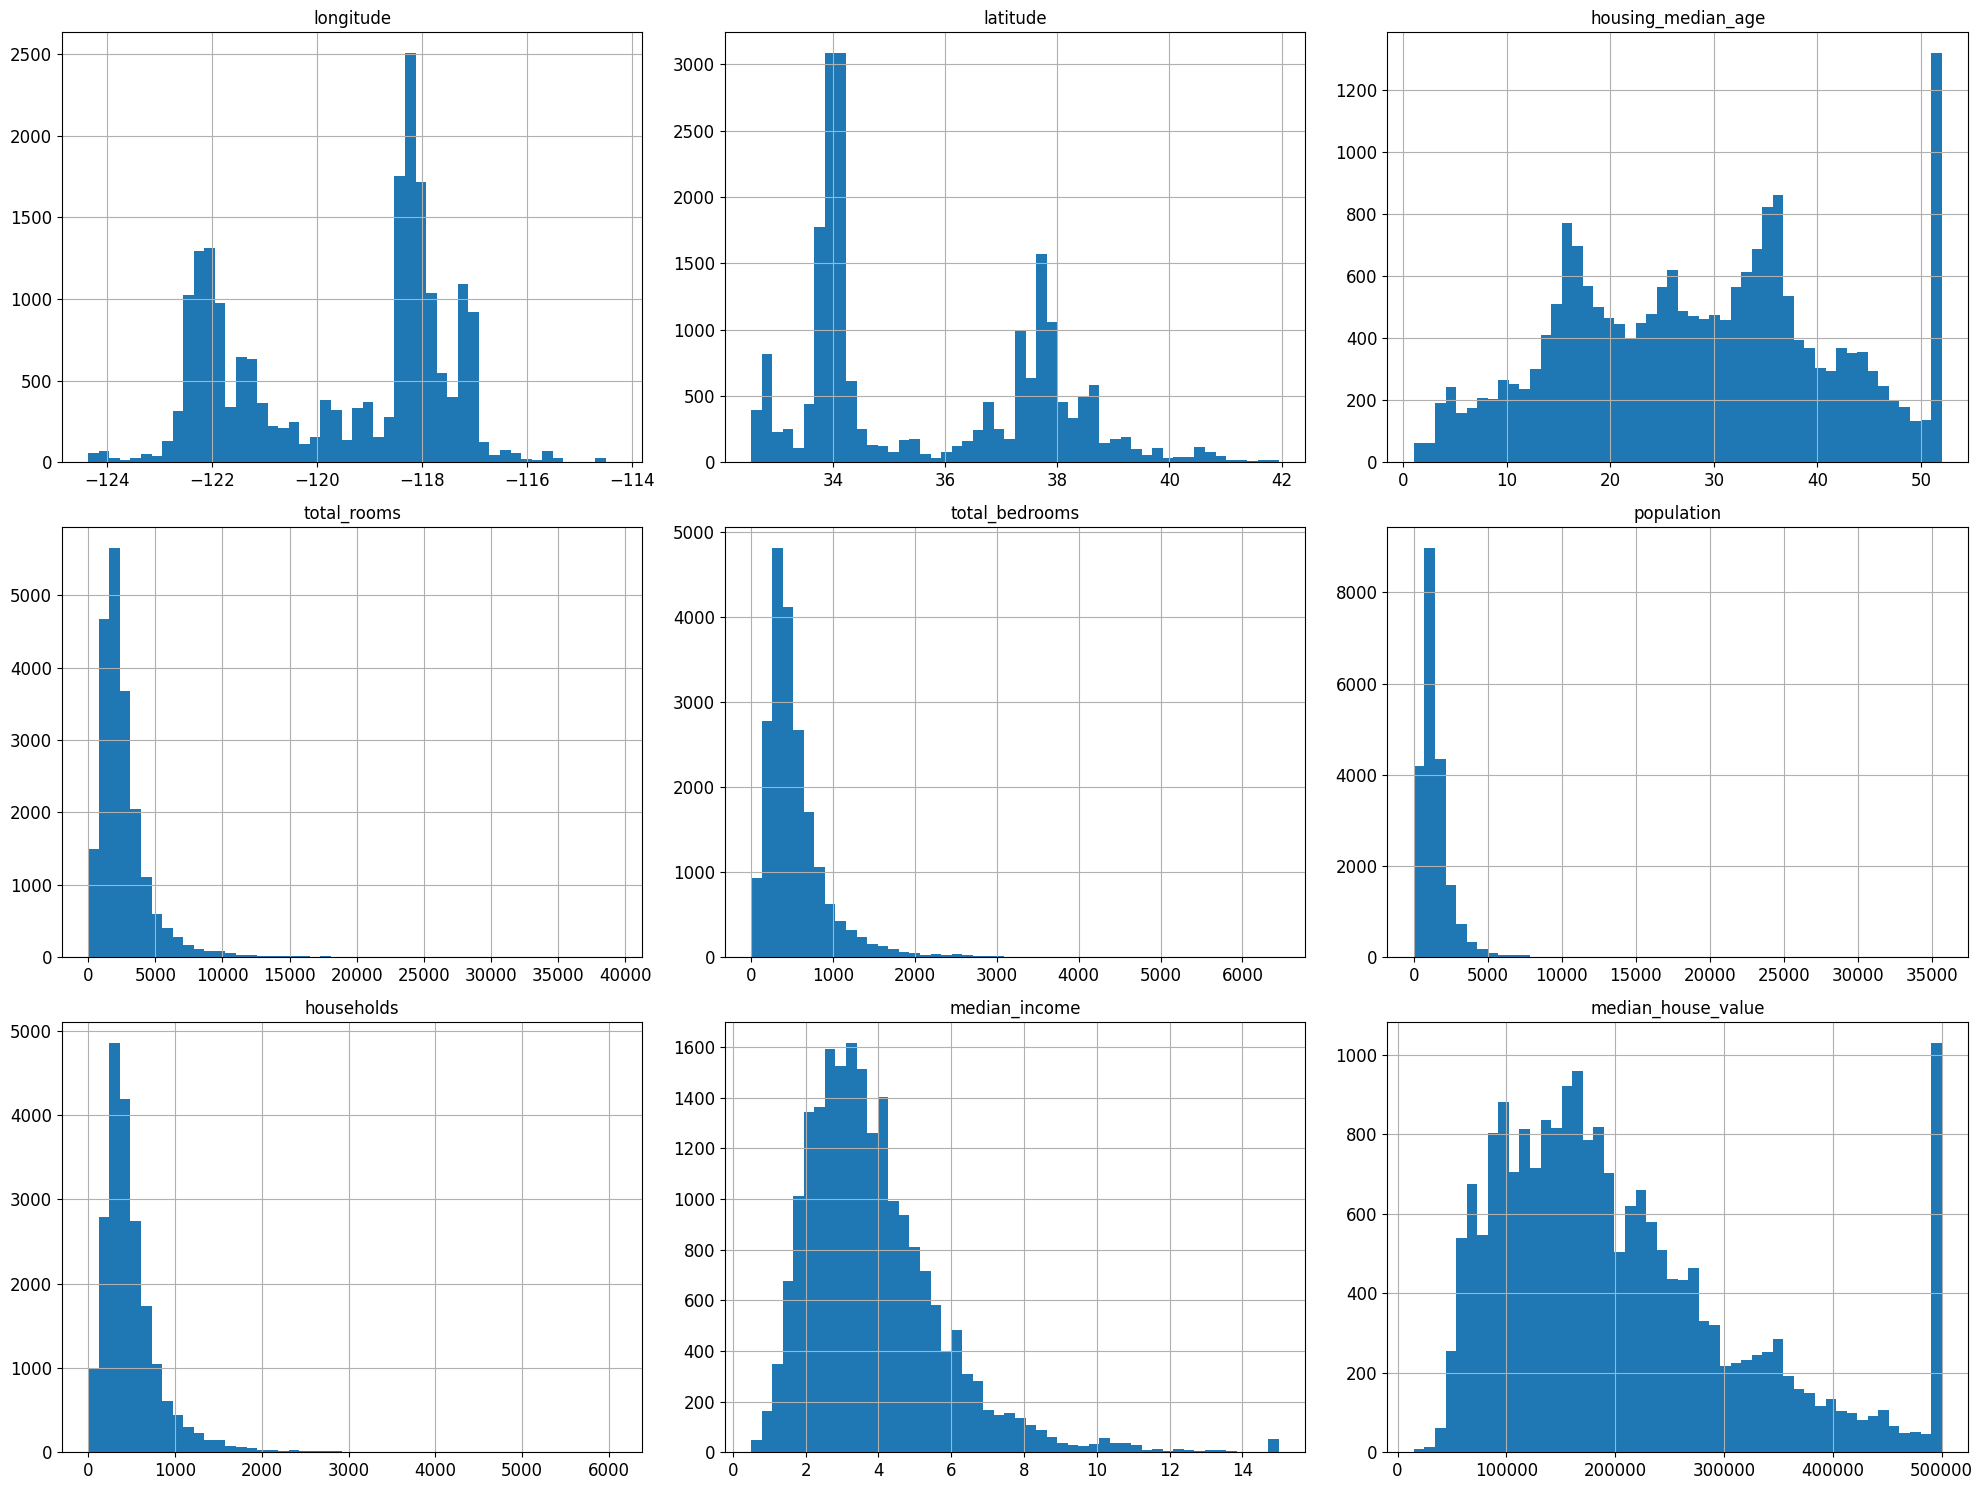

In [8]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20, 15))
save_fig('attribute_histogram_plots')

plt.show()

- 가우시안 분포가 되지 못하는 경우가 다양하다. 이런 데이터들을 전처리를 통해 정규분포화 시켜야 한다. 
- 각 분포별 x축이 다르다. 이를 일정하게 맞추는 작업이 추후 필요할 것 같다. 

# TestSet, TrainingSet 분리

- 테스트와 훈련 데이터가 중복될 경우, 과적합이 발생할 수 있다.
- 이를 방지하기 위해 훈련 데이터셋과 테스트 데이터셋을 사전에 분리한다. 

In [9]:
import numpy as np

# 실제로 scikit-learn에서 테스트 데이터를 분리해주는 함수가 존재한다 sklearn.train_test_split()
def split_train_set(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_set(housing, 0.2)

In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_set_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_:test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

- 실제 개발 중 데이터셋에 변경이 있을 수 있다. 이 때 데이터를 다시 받을 수 있는 로직을 호출하면 된다. 

In [12]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_set_by_id(housing_with_id, 0.2, "index")

In [13]:
import sklearn.model_selection


train_set, test_set = sklearn.model_selection.train_test_split(housing, test_size=0.2, random_state=42)

- 결국 sklearn쓰는게 제일 편하다

In [14]:
test_set.head() # 인덱스가 다 섞임

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


# 예제 - median_income

- median_income은 연속적인 값이다. 
- 이를 categorized factor로 만들어주어야 한다. 
- 특정 범주를 정해 라벨링을 해주는 방식으로 카테고리화 시킨다. 

In [15]:
housing['income_cat'] = pd.cut(
    housing['median_income'],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

In [16]:
housing['income_cat'].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

<Axes: >

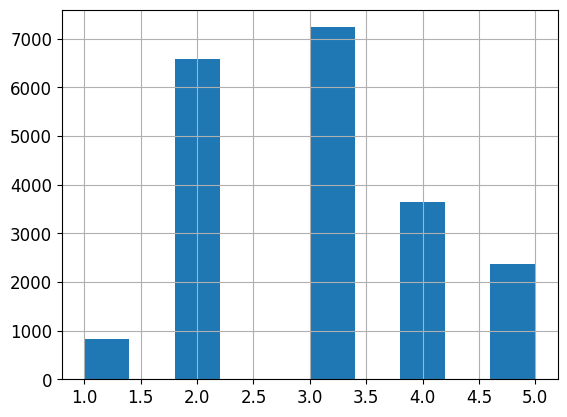

In [17]:
housing['income_cat'].hist()

In [18]:
import sklearn.model_selection as model_selection

split = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [19]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [20]:
housing['income_cat'].value_counts() / len(housing)

income_cat
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: count, dtype: float64

- 사실 stratify로 train_test_split해주는 로직은 sklearn.model_selection에 이미 존재한다.

In [21]:
st_train_set, st_test_set = model_selection.train_test_split(housing, test_size=0.2, random_state=42, stratify=housing['income_cat'])

In [22]:
st_train_set['income_cat'].value_counts() / len(st_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [23]:
for set_ in (strat_test_set, strat_train_set):
    set_.drop('income_cat', axis=1, inplace=True)

# 데이터이해를 위한 탐색과 시각화

In [24]:
housing_traing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

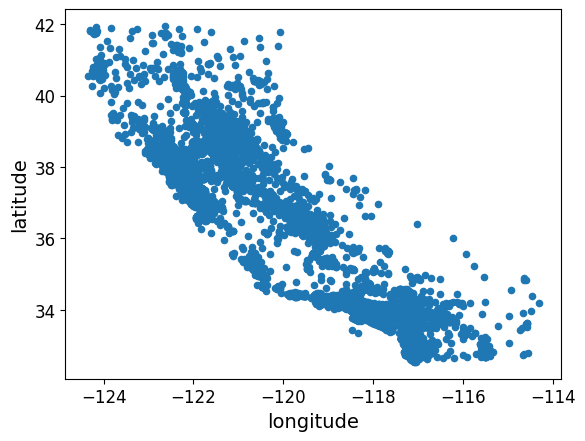

In [25]:
housing_traing.plot(kind='scatter', x='longitude', y='latitude')

<Axes: xlabel='longitude', ylabel='latitude'>

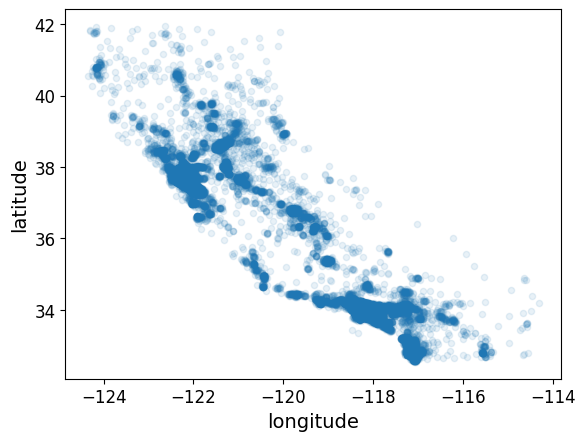

In [26]:
housing_traing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)


- scatter plot으로 전체의 분포를 점으로 찍을 수 있다. 
- 그런데 alpha로 조금 더 진한 부분이 선택적으로 보이게 된다. 
- `alpha`를 이용해 투명도를 설정할 수 있다. 이를 통해 빈도가 높은 곳은 진하게 확인할 수 있다. 

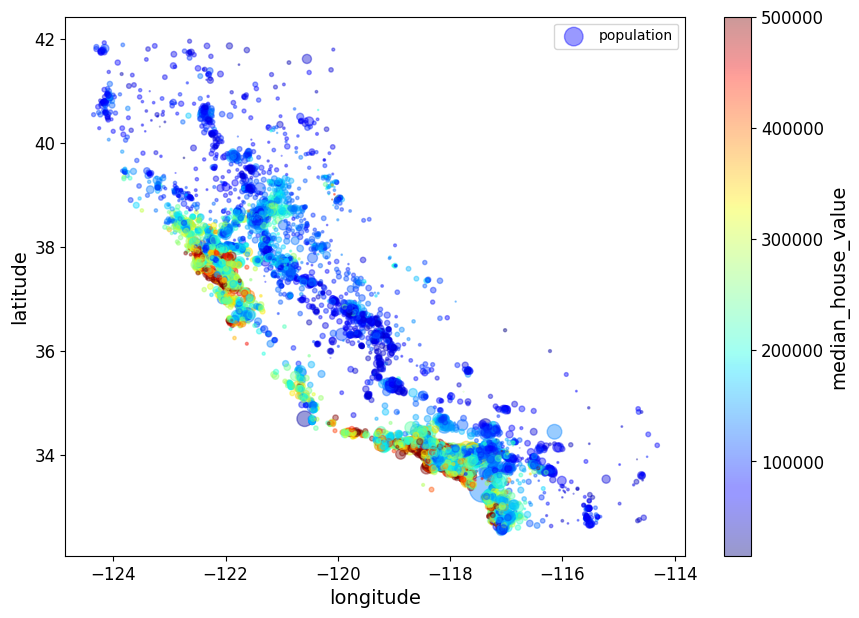

In [27]:
housing_traing.plot(
    kind='scatter', 
    x='longitude', 
    y='latitude', 
    alpha=0.4, 
    s=housing_traing['population']/100, 
    label='population', 
    figsize=(10, 7), 
    c='median_house_value',
    cmap=plt.get_cmap('jet'), 
    colorbar=True, 
    sharex=False)
plt.legend()


- 현재의 구조는 위도, 경도를 통해 생성되어있는 구조이다. 
- 이를 지도 위에 표기해보자. 

In [28]:
image_path = os.path.join(ROOT_DIR, 'images', 'end_to_end_project')
os.makedirs(image_path, exist_ok=True)
filename = 'california.png'
url = DOWNLOAD_ROOT + 'images/end_to_end_project/' + filename
urllib.request.urlretrieve(url, os.path.join(image_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x2093740fe10>)

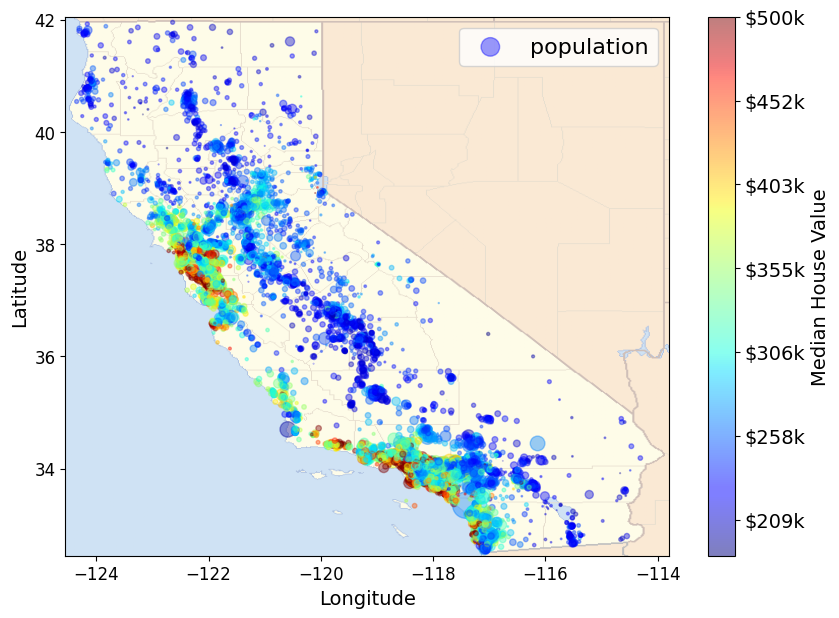

In [29]:
import matplotlib.image as mpimg

california_img = mpimg.imread(os.path.join(image_path, filename))
ax = housing_traing.plot(
    kind='scatter', 
    x='longitude', 
    y='latitude', 
    alpha=0.4, 
    s=housing_traing['population']/100, 
    label='population', 
    figsize=(10, 7), 
    c='median_house_value',
    cmap=plt.get_cmap('jet'), 
    colorbar=False)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5, cmap=plt.get_cmap('jet'))

plt.ylabel('Latitude', fontsize = 14)
plt.xlabel('Longitude', fontsize = 14)

prices = housing_traing['median_house_value']
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(['$%dk'%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=14)

plt.legend(fontsize=16)
plt.show()


- 지금까지는 데이터를 시각화해 인사이트를 얻기 위한 과정이었다. 
- 이번엔 각 데이터간의 상관관계를 찾아야 한다.
- 이를 위해 상관관계 행렬을 얻기 위한 함수인 `corr()`이 존재한다. 
- 현재 버전에서, 상관행렬 생성시 String 타입은 행렬화시킬 수 없다.
- `pandas.get_dummies`를 이용해 처리하자. 
    - `get_dummies` : 문자열형의 categorized data를 numerical data로 처리한다. 
    - `HANDS ON MACHINE LEARNING 2판`에서는 해당 로직이 바로 된다는 강의였지만, 불가능!
    - 그런데, 지금과 같은 경우 문자열이 바로 처리되지만, 그렇지 못하는 nullable한 케이스는 고려할 필요 없을까?

In [30]:
corr_matrix = pd.get_dummies(housing_traing, drop_first=True).corr()

In [31]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value            1.000000
median_income                 0.687151
ocean_proximity_NEAR BAY      0.158691
ocean_proximity_NEAR OCEAN    0.137332
total_rooms                   0.135140
housing_median_age            0.114146
households                    0.064590
total_bedrooms                0.047781
ocean_proximity_ISLAND        0.013708
population                   -0.026882
longitude                    -0.047466
latitude                     -0.142673
ocean_proximity_INLAND       -0.482853
Name: median_house_value, dtype: float64

- 상관계수는 0에 가까울 수록 의미가 없고, 1에 가까울 수록 관계가 큰 것을 의미한다. 

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

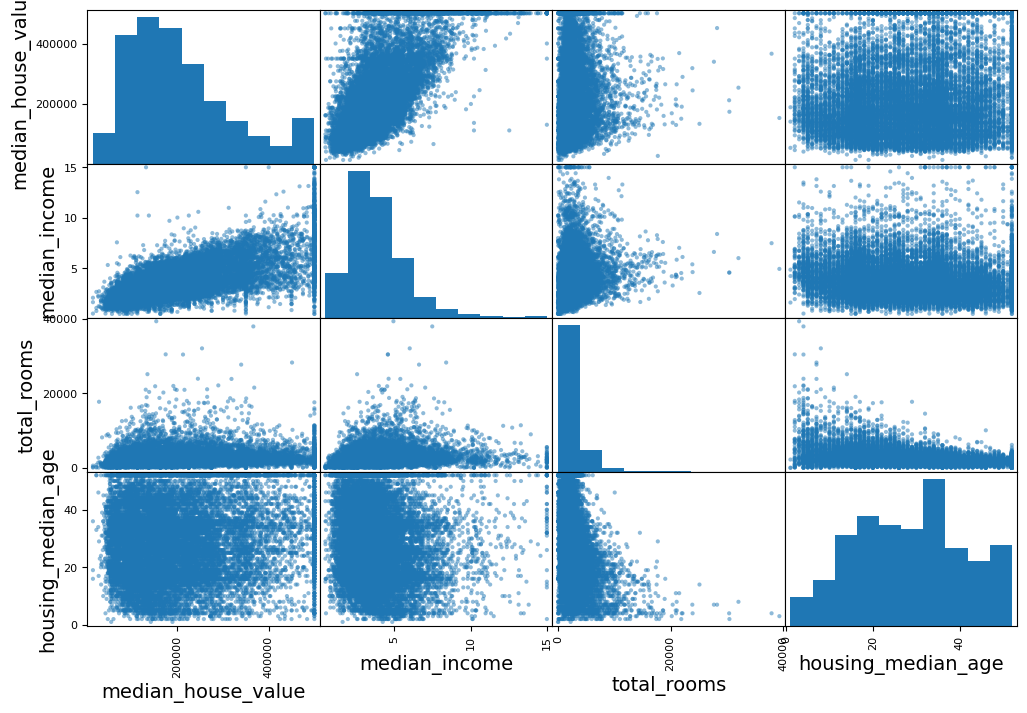

In [32]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
exclude_attributes = ['ocean_proximity']

scatter_matrix(housing_traing[attributes], figsize=(12, 8))


- 총 4개의 데이터를 이용해 만들 수 있는 모든 경우의 수에 대한 scatter plot을 표현한 상태이다. 
- x와 y가 같은 scatter plot은 histogram으로 대체된다. 

(np.float64(0.0), np.float64(16.0), np.float64(0.0), np.float64(550000.0))

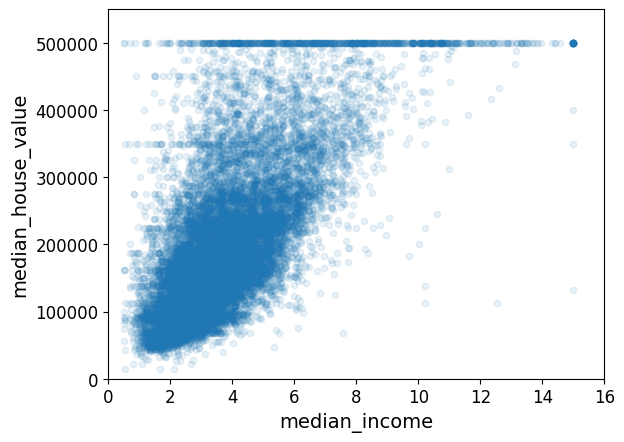

In [33]:
housing_traing.plot(kind='scatter', x='median_income', y='median_house_value', alpha = 0.1)
plt.axis([0, 16, 0, 550000])

- 위의 데이터중, 특정 데이터를 조회해 디테일을 볼 수 있다. 
- median_income, median_house_value는 직선형 구조임을 알 수 있다. 

## 수동으로 새로운 특성을 추가하기

In [34]:
# housing_traing = housing_traing.drop(columns=['rooms_per_household', 'bedroom_per_room', 'population_per_household'])

housing_traing['rooms_per_household'] = housing_traing['total_rooms'] / housing_traing['households']
housing_traing['bedroom_per_room'] = housing_traing['population'] / housing_traing['households']
housing_traing['population_per_household'] = housing_traing['population'] / housing_traing['households']

attributes.append('rooms_per_household')
attributes.append('bedroom_per_room')
attributes.append('population_per_household')

In [35]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age', 'rooms_per_household', 'bedroom_per_room', 'population_per_household', 'latitude', 'longitude']

corr_matrix = housing_traing[attributes].corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
bedroom_per_room           -0.021991
population_per_household   -0.021991
longitude                  -0.047466
latitude                   -0.142673
Name: median_house_value, dtype: float64

- 조회결과, `rooms_per_household`가 생각보다 높은 상관계수를 가지고 있다. 
- 이에 대한 산점도를 조회해본다. 

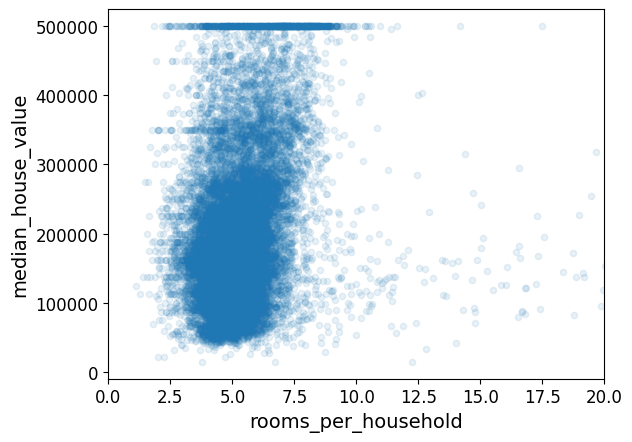

In [36]:
housing_traing.plot(kind='scatter', x='rooms_per_household', y='median_house_value', alpha=0.1)
plt.xlim(0, 20)
plt.show()

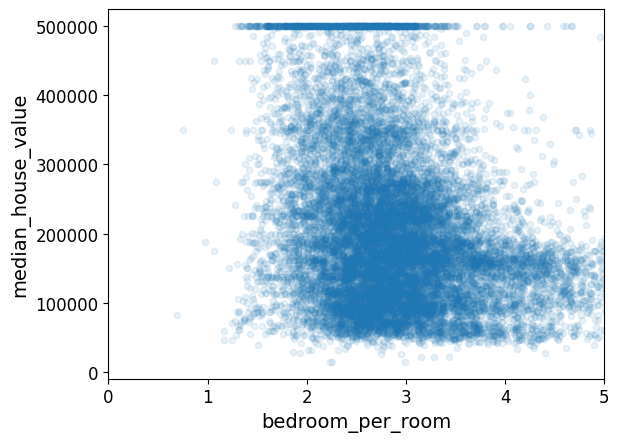

In [37]:
housing_traing.plot(kind='scatter', x='bedroom_per_room', y='median_house_value', alpha=0.1)
plt.xlim(0, 5)
plt.show()

- 아주 미세하게 기울어진 선형임을 알 수 있다. 
- 이걸 어떻게 활용해야 할까?

In [38]:
housing_traing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedroom_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,3.096469,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,11.584825,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.692308,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,2.431352,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,2.817661,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,3.281420,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1243.333333,1243.333333


# 머신러닝 알고리즘을 위한 데이터 준비

In [39]:
housing = strat_test_set.drop('median_house_value', axis=1)
housing_labels = strat_test_set['median_house_value'].copy()

In [40]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
11441,-117.98,33.73,18.0,3833.0,NaN,2192.0,996.0,3.4679,<1H OCEAN
19890,-119.15,36.29,18.0,1435.0,NaN,657.0,254.0,2.4281,INLAND
3912,-118.55,34.19,18.0,5862.0,NaN,3161.0,1280.0,3.1106,<1H OCEAN
8530,-118.35,33.90,31.0,1547.0,NaN,956.0,287.0,3.4698,<1H OCEAN
11311,-117.96,33.78,33.0,1520.0,NaN,658.0,242.0,4.8750,<1H OCEAN


In [41]:
# 판다스를 이용한 빈 값 핸들링 방법

# sample_incomplete_rows.dropna(axis=1) # NaN인 데이터를 삭제한다. 
# sample_incomplete_rows.drop('total_bedrooms', axis=1) # NaN인 열을 삭제한다. axis=0이면 행을 삭제한다. 
# sample_incomplete_rows['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace = True) # 빈 해당 열의 median으로 값을 채우기

보통은 판다스를 이용한 빈 데이터 핸들링이 아닌, 사이킷런을 이용한다. 

In [42]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median') # mean, most_frequent등의 방법으로 null을 대체할 다른 방법도 존재한다. 

중간값이 수치형 특성에서만 계산될 수 있기 때문에, 해당 값을 계산하기 위해서는 텍스트 특성이 존재하면 안된다. 
현재 `ocean_proximity`라는 특성이 텍스트이기 때문에, 해당 특성을 제거하고 생성한다. 

In [43]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [44]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [45]:
imputer.statistics_

array([-118.46  ,   34.22  ,   28.    , 2159.5   ,  442.    , 1172.5   ,
        416.    ,    3.5132])

In [46]:
housing_num.median().values

array([-118.46  ,   34.22  ,   28.    , 2159.5   ,  442.    , 1172.5   ,
        416.    ,    3.5132])

확인했을 때 housing_num.median()과 같은 값을 imputer를 통해 얻을 수 있다. 
- 이게 왜 유의미한걸까?
    - `SimpleImputer`는 비어있는 값을 채울 때 평균값, 중앙값, 최빈값등의 전략중 하나를 선택해서 사용한다. 
    - median값은, 이 중 중앙값을 말한 것이다. 
    - 여기에서 `median()`은 `Pandas`를 활용한 경우.
    - 결국, `sklearn`을 이용해 하는 전처리가 충분히 실용성이 있다는 것을 증명한다. 


In [48]:
X = imputer.transform(housing_num)

In [49]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [51]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
11441,-117.98,33.73,18.0,3833.0,442.0,2192.0,996.0,3.4679
19890,-119.15,36.29,18.0,1435.0,442.0,657.0,254.0,2.4281
3912,-118.55,34.19,18.0,5862.0,442.0,3161.0,1280.0,3.1106
8530,-118.35,33.90,31.0,1547.0,442.0,956.0,287.0,3.4698
11311,-117.96,33.78,33.0,1520.0,442.0,658.0,242.0,4.8750


In [53]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816
17352,-120.42,34.89,24.0,2020.0,307.0,855.0,283.0,5.0099
3505,-118.45,34.25,36.0,1453.0,270.0,808.0,275.0,4.3839
7777,-118.10,33.91,35.0,1653.0,325.0,1072.0,301.0,3.2708
14155,-117.07,32.77,38.0,3779.0,614.0,1495.0,614.0,4.3529


이제 문자열 데이터를 카테고리화시키자

In [59]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
5241,<1H OCEAN
17352,<1H OCEAN
3505,<1H OCEAN
7777,<1H OCEAN
14155,NEAR OCEAN
7057,<1H OCEAN
33,NEAR BAY
17049,NEAR OCEAN
18164,<1H OCEAN
10444,NEAR OCEAN


In [56]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [4.],
       [0.],
       [3.],
       [4.],
       [0.],
       [4.]])

In [60]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

카테고리를 조회하면 각 문자열 데이터가 어떠헥 카테고리화되었는지 알 수 있다. 
위에서 나온 값은, 현재 카테고리 배열의 인덱스로 되어있다. 
이 떄 각 인덱스는 의미가 존재하지 않아, 실제 의미가 있는 `등급`, `등수`, `순위`등의 데이터를 카테고리화시키면 의미가 퇴색될 수 있다. 

In [61]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4128 stored elements and shape (4128, 5)>

## One Hot Encoding

- 카테고리형 데이터를 모델이 이해할 수 있도록 변환하는 기법
- 위에서 했던 레이블인코딩(인덱스기반)과 다르게 각 카테고리를 단위벡터로 만들어준다. (이래서 우리가 이진벡터를 배웠구나?)